In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import itertools
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv(r"data\model_input.csv")
dataset = df.drop(columns=["Unnamed: 0", "Min Temp", "Max Temp", "percentile_25", "percentile_75"])
dataset

,Mean Temp,RAINFALL,month_year,median
0,22.178833,0.085958,2013-04,0.455720
1,26.819516,0.413366,2013-05,0.665620
2,25.359833,31.586529,2013-06,0.226039
3,25.052258,20.653476,2013-07,0.249820
4,24.369032,24.446940,2013-08,0.267682
...,...,...,...,...
112,25.292838,13.266669,2022-08,0.238900
113,23.823002,11.473897,2022-09,0.244405
114,20.420344,3.875470,2022-10,0.419238
115,16.548313,0.000000,2022-11,0.518314


In [3]:
ts_dataset = dataset.drop(columns='month_year')
ts_dataset.rename(columns={'median': "Median NDSI"}, inplace=True)
ts_dataset

,Mean Temp,RAINFALL,Median NDSI
0,22.178833,0.085958,0.455720
1,26.819516,0.413366,0.665620
2,25.359833,31.586529,0.226039
3,25.052258,20.653476,0.249820
4,24.369032,24.446940,0.267682
...,...,...,...
112,25.292838,13.266669,0.238900
113,23.823002,11.473897,0.244405
114,20.420344,3.875470,0.419238
115,16.548313,0.000000,0.518314


In [4]:
target = ts_dataset["Median NDSI"]
exog = ts_dataset[["Mean Temp", "RAINFALL"]]

In [5]:
temp_result = adfuller(exog['Mean Temp'])
print("ADF Statistic:", temp_result[0])
print("p-value:", temp_result[1])

if temp_result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -1.3002025817123515
p-value: 0.6290796272051388
The series is non-stationary. Differencing may be required.


In [6]:
temp_diff = exog['Mean Temp'].diff().dropna()
temp_result = adfuller(temp_diff)
print("ADF Statistic:", temp_result[0])
print("p-value:", temp_result[1])

if temp_result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -10.91358497339599
p-value: 1.0814955491683104e-19
The series is stationary.


In [7]:
rain_result = adfuller(exog['RAINFALL'])
print("ADF Statistic:", rain_result[0])
print("p-value:", rain_result[1])

if rain_result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -2.7960304268516785
p-value: 0.05884303439217425
The series is non-stationary. Differencing may be required.


In [8]:
rain_diff = exog['RAINFALL'].diff().dropna()
rain_result = adfuller(rain_diff)
print("ADF Statistic:", rain_result[0])
print("p-value:", rain_result[1])

if rain_result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -6.788368773733696
p-value: 2.39963208296417e-09
The series is stationary.


In [9]:
exog_diff = pd.DataFrame({
    'Mean Temp': temp_diff,
    'RAINFALL': rain_diff
})

In [10]:
target = target.iloc[1:]

In [11]:
print(target)

1      0.665620
2      0.226039
3      0.249820
4      0.267682
5      0.139340
         ...   
112    0.238900
113    0.244405
114    0.419238
115    0.518314
116    0.400156
Name: Median NDSI, Length: 116, dtype: float64


In [12]:
print(exog_diff)

     Mean Temp   RAINFALL
1     4.640683   0.327409
2    -1.459683  31.173162
3    -0.307575 -10.933053
4    -0.683226   3.793465
5    -0.407699 -17.127739
..         ...        ...
112   0.050664  -2.669182
113  -1.469836  -1.792772
114  -3.402658  -7.598428
115  -3.872032  -3.875470
116  -3.873498   0.000000

[116 rows x 2 columns]


In [13]:
result = adfuller(target)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -1.8273700201286942
p-value: 0.3669603750925443
The series is non-stationary. Differencing may be required.


In [14]:
target_diff = target.diff().dropna()
result = adfuller(target_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -9.28390565634351
p-value: 1.2300692581557481e-15
The series is stationary.


In [15]:
decomposition = seasonal_decompose(target, period=12, model='additive')

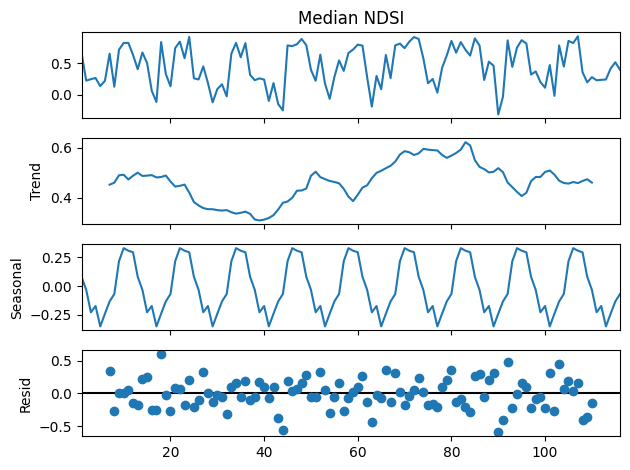

In [16]:
decomposition.plot();

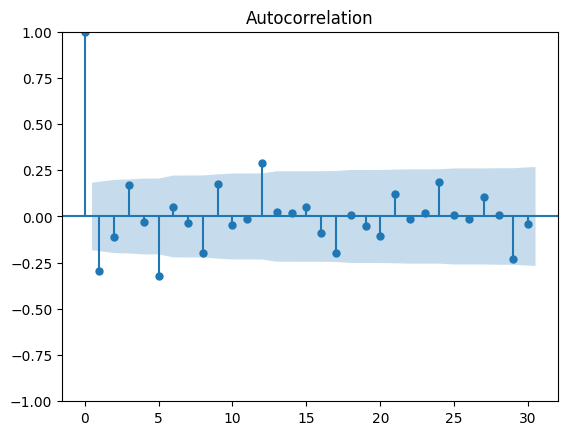

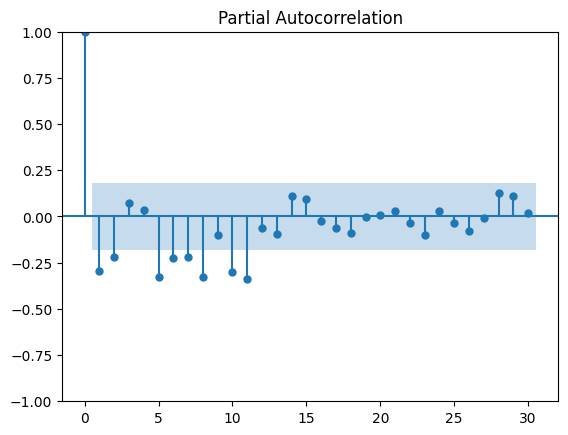

In [17]:
plot_acf(target_diff, lags=30)
plt.show()

plot_pacf(target_diff, lags=30)
plt.show()

In [18]:
train_target = target[:-12]
test_target = target[-12:]
train_exog = exog_diff[:-12]
test_exog = exog_diff[-12:]

In [19]:
model = auto_arima(train_target, exogenous=train_exog, seasonal=True, m=12, start_p=0, max_p=5,start_q=0, max_q=11, 
                   stepwise=False, trace=True, error_action='ignore', suppress_warnings=True, allow_insample=True)
print(model.summary())

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=64.152, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=41.876, Time=0.10 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=31.804, Time=0.14 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=28.555, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=27.717, Time=0.38 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=26.360, Time=0.33 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=27.552, Time=0.49 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=29.560, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=49.409, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=35.095, Time=0.07 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=25.707, Time=0.18 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=25.876, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=26.369, Time=0.54 sec
 ARIMA(0,0,1)(2,0,0)[12] interc

In [24]:
error1 = []
error2 = []
error3 = []
test_split = []

def run_SARIMAX(y, exog_diff, test_percent):
    num = int(test_percent*len(y)/100)
    train = y[:-num]
    test = y[-num:]
    train_exog = exog_diff[:-num]
    test_exog = exog_diff[-num:]
    scaler = StandardScaler()
    train_exog = scaler.fit_transform(train_exog)
    test_exog = scaler.transform(test_exog)
    model = SARIMAX(train, exog=train_exog, order=(2,0,2), seasonal_order=(0,0,1,12))
    model_fit = model.fit()
    model_pred = model_fit.predict(start = len(train), end = len(y)-1, exog=test_exog)
    rmse = np.sqrt(mse(test, model_pred))
    test_split.append(test_percent)
    error1.append(rmse)
    r2_train = r2_score(train, model_fit.predict(start = 0, end = len(train)-1, exog = train_exog))
    error2.append(r2_train)
    r2_test = r2_score(test, model_pred)
    error3.append(r2_test)
    print("RMSE = ", rmse)
    print("R2 Train = ", r2_train)
    print("R2 Test = ", r2_test)

    plt.plot(y.index, y, c = 'orange')
    plt.plot(y.index, model_fit.predict(start=0,end=len(y)-1,exog=test_exog), c = 'cyan')
    plt.scatter(y.index, y, c = 'black')
    plt.scatter(y.index, model_fit.predict(start=0,end=len(y)-1,exog=test_exog), c = 'brown')
    plt.xlabel("Time")
    plt.ylabel("Median NDSI of Image")
    plt.title("Actual vs Prediction SARIMAX")
    plt.legend(["Actual", "Prediction"])
    plt.show()

    return model_fit

RMSE =  0.19462570801445467
R2 Train =  0.30895633761183805
R2 Test =  0.3141156031543273


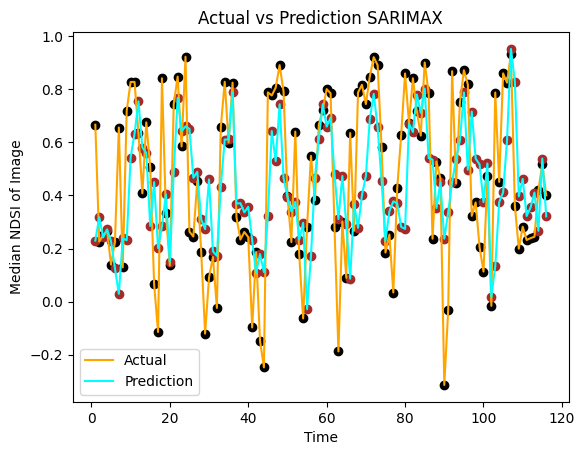

RMSE =  0.27532644042753285
R2 Train =  0.35412713304885857
R2 Test =  -0.01996442706956847


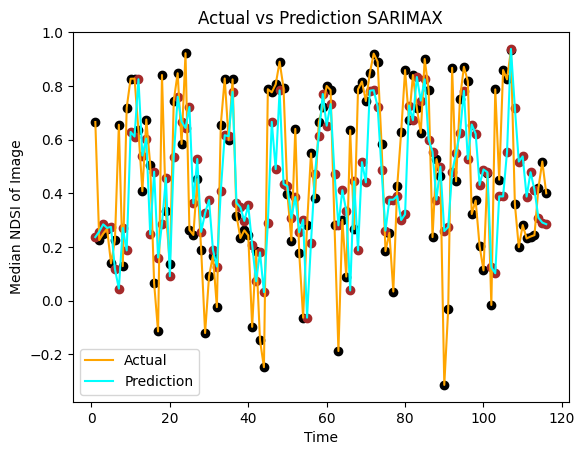

RMSE =  0.2791585573712994
R2 Train =  0.33575890106358464
R2 Test =  0.16176671804534737


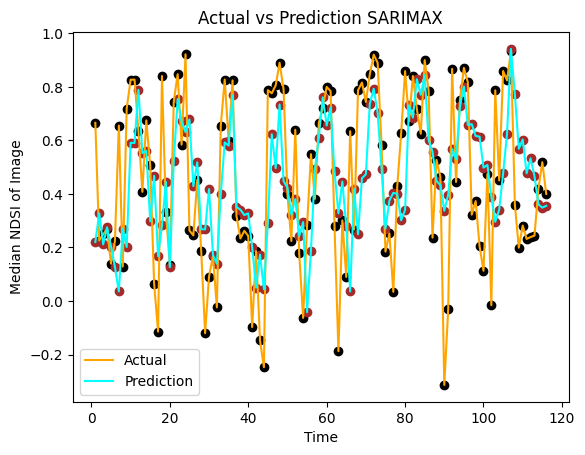

RMSE =  0.27546238553325153
R2 Train =  0.3177546702489935
R2 Test =  0.1931847594057251


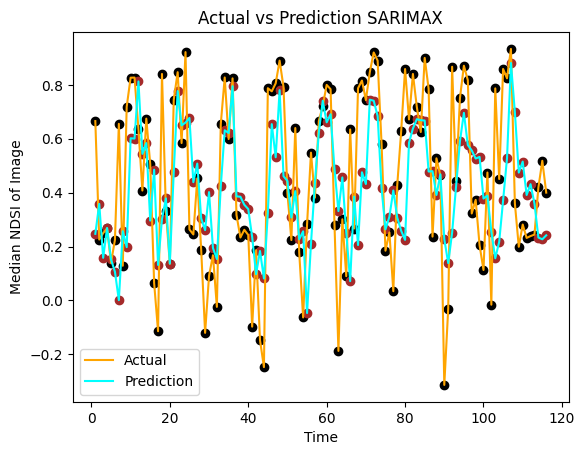

RMSE =  0.3022229161783965
R2 Train =  0.3835101719637386
R2 Test =  0.052040084050134716


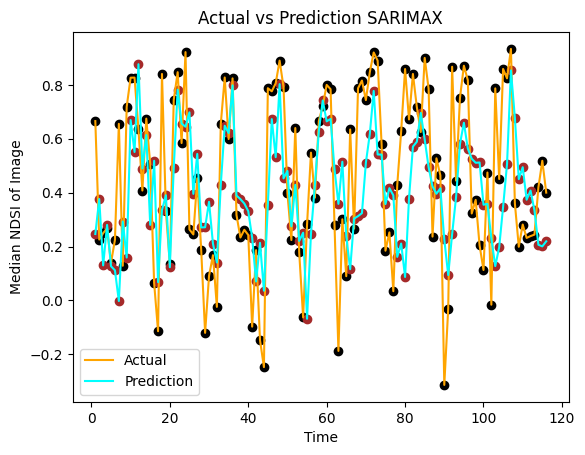

RMSE =  0.3051670320814262
R2 Train =  0.38885026865813377
R2 Test =  0.0022713111707380884


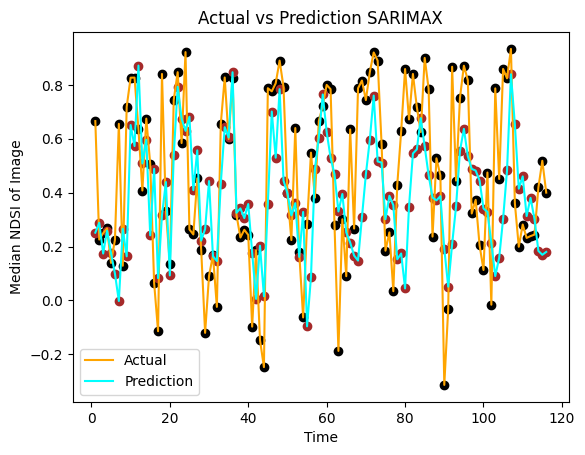

RMSE =  0.2854506486477162
R2 Train =  0.2524017731052066
R2 Test =  0.212396144120793


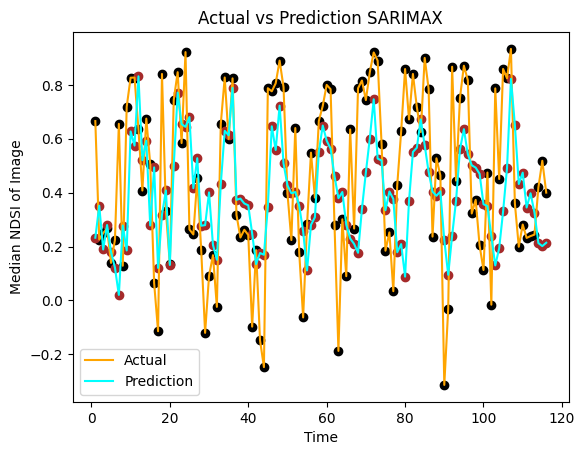

RMSE =  0.2825800625465656
R2 Train =  0.14867538914157274
R2 Test =  0.2281575496107845


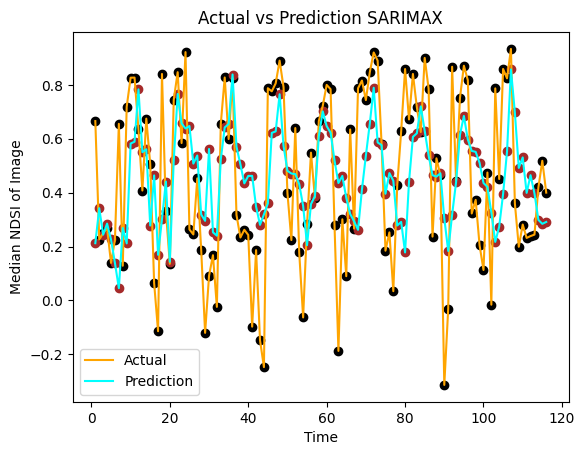

RMSE =  0.45240246381588023
R2 Train =  -0.05569207658259434
R2 Test =  -0.9730277709650339


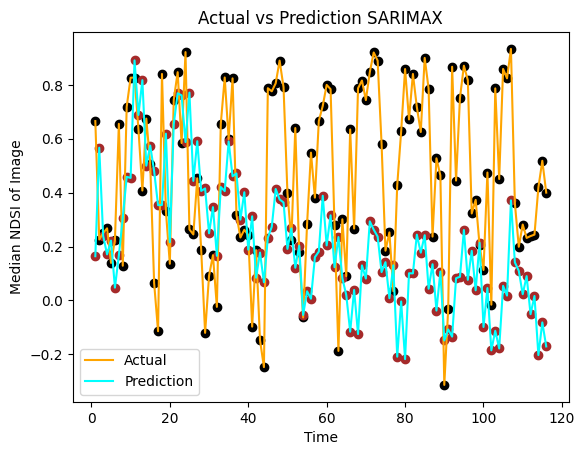

In [25]:
for i in range(10,100,10):
    run_SARIMAX(target, exog_diff, i)

import warnings 
warnings.filterwarnings('ignore')

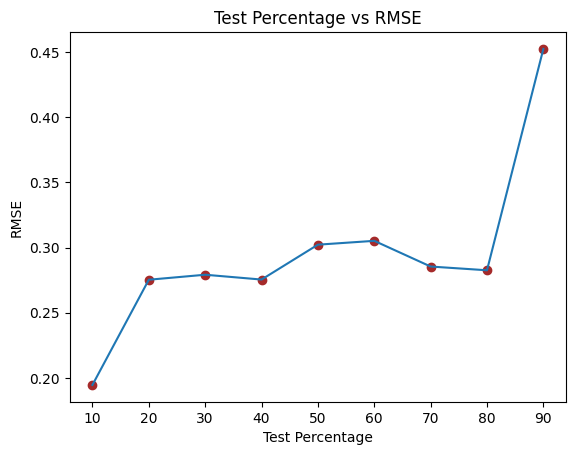

In [26]:
plt.plot(test_split,error1)
plt.scatter(test_split,error1, c='brown')
plt.xlabel("Test Percentage")
plt.ylabel("RMSE")
plt.title("Test Percentage vs RMSE")
plt.show()

In [28]:
error1_arima = [0.23035502435550442, 0.3169179236287131, 0.2605882917978978, 0.5160479031433169, 0.4414952187650623, 0.29682666178423245, 0.7429539061075802, 0.9954982124903271]
error2_arima = [0.14415518920543502, 0.17233097874554393, 0.19129323085165606, 0.14333519068796607, 0.19340645153321268, 0.22496233537100807, 0.23686584012593837, 0.0902358947585592]
error3_arima = [0.03917146860081666, -0.35139649757407065, 0.2789672867238736, -1.8315844612339207, -1.022959552750625, 0.05651702747391352, -4.335430977121823, -8.463410840465007]

In [32]:
error1

[0.19462570801445467,
 0.27532644042753285,
 0.2791585573712994,
 0.27546238553325153,
 0.3022229161783965,
 0.3051670320814262,
 0.2854506486477162,
 0.2825800625465656,
 0.45240246381588023,
 0.19462570801445467]

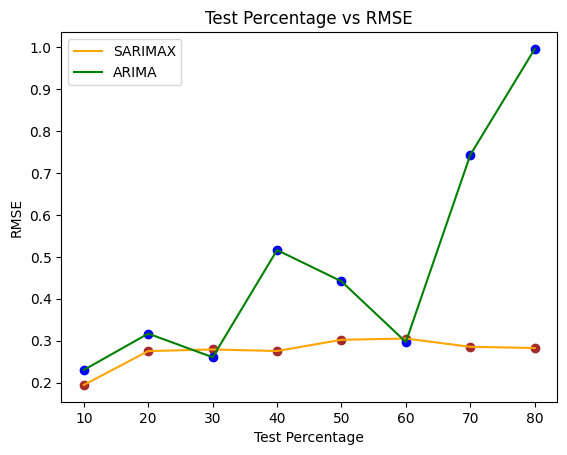

In [36]:
plt.plot(test_split[0:8],error1[0:8], c='orange')
plt.plot(test_split[0:8],error1_arima, c='green')
plt.scatter(test_split[0:8],error1[0:8], c='brown')
plt.scatter(test_split[0:8],error1_arima, c='blue')
plt.legend(["SARIMAX", "ARIMA"])
plt.xlabel("Test Percentage")
plt.ylabel("RMSE")
plt.title("Test Percentage vs RMSE")
plt.show()

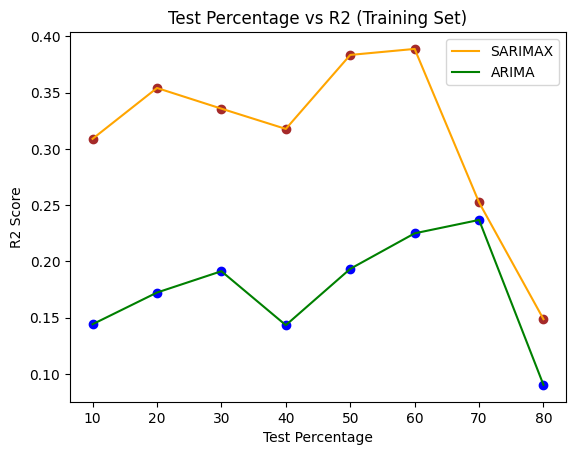

In [38]:
plt.plot(test_split[0:8],error2[0:8], c='orange')
plt.plot(test_split[0:8],error2_arima, c='green')
plt.scatter(test_split[0:8],error2[0:8], c='brown')
plt.scatter(test_split[0:8],error2_arima, c='blue')
plt.legend(["SARIMAX", "ARIMA"])
plt.xlabel("Test Percentage")
plt.ylabel("R2 Score")
plt.title("Test Percentage vs R2 (Training Set)")
plt.show()

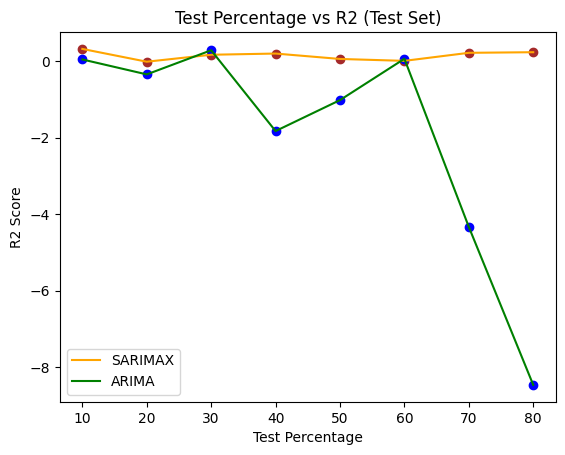

In [39]:
plt.plot(test_split[0:8],error3[0:8], c='orange')
plt.plot(test_split[0:8],error3_arima, c='green')
plt.scatter(test_split[0:8],error3[0:8], c='brown')
plt.scatter(test_split[0:8],error3_arima, c='blue')
plt.legend(["SARIMAX", "ARIMA"])
plt.xlabel("Test Percentage")
plt.ylabel("R2 Score")
plt.title("Test Percentage vs R2 (Test Set)")
plt.show()

RMSE =  0.19462570801445467
R2 Train =  0.30895633761183805
R2 Test =  0.3141156031543273


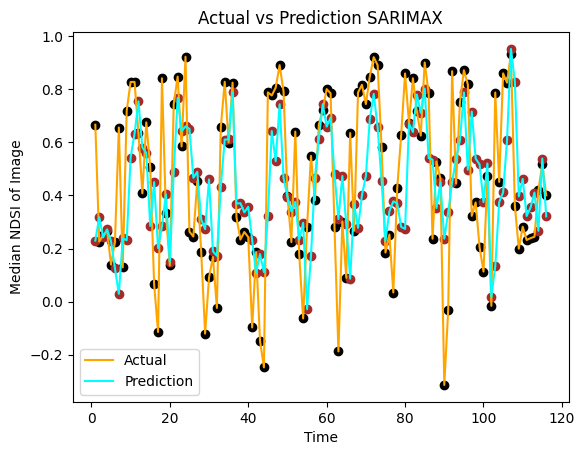

x1          0.154157
x2          0.012052
ar.L1       0.070465
ar.L2       0.929244
ma.L1       0.021740
ma.L2      -0.978188
ma.S.L12    0.359451
sigma2      0.068334
dtype: float64

In [27]:
params = run_SARIMAX(target, exog_diff, 10).params
params